Start the workflow program 
1. Create the list of inputs (time is very closely related to the g2 max that will be given here)
2. Create the lowering and raising operators for the qubits and the hilbert space
3. Build the set of operator combinations (All terms will have a different coefficient)
4. Impliment the ability to have multiple copies of a gate 
5. Run the simulation with qubits being varied and then average over the first extra qubit then do the same thing but holding that extra qubit at the best point
6. Give the list of relevant outputs (the topology that this was made for and the set of frequencies that can be used to create the system for an experimentalist)

In [1]:
import numpy as np
import qutip as qt
import h5py 
from quantum_logical.pulsesim import QuantumSystem, Pulse
from quantum_logical.pulsesim.mode import QubitMode, SNAILMode, CavityMode
from quantum_logical.pulsesim.build_hamiltonian import Build_hamiltonian
import matplotlib.pyplot as plt
from itertools import product
from quantum_logical.work_flow import Work_flow
from quantum_logical.Work_flow_general import Work_flow1
from tqdm import tqdm

In [2]:
dim = 2
Qubit_modes = []
freq_list = [4,2,2.5,3]
for i in range(len(freq_list)):
            Qubit_modes.append(QubitMode(mode_type = "Qubit",
            name=f"q{i + 1}", dim=dim, freq=freq_list[i], alpha=-0.161, T1=1e2, T2=5e1
        ))
        

ws = Qubit_modes[0].freq + ((Qubit_modes[0].freq - Qubit_modes[1].freq) / 3)

snail = SNAILMode(mode_type = "Snail", name="s", freq=ws, g3=0.3, dim=10, T1=1e3, T2=5e2)
_couplings = {
    frozenset([Qubit_modes[0], snail]): 2 * np.pi * 0.05467,
    frozenset([Qubit_modes[1], snail]): 2 * np.pi * 0.0435,
    frozenset([Qubit_modes[2], snail]): 2 * np.pi * 0.04875,
}

qs = QuantumSystem(Qubit_modes + [snail], couplings=_couplings)
qs


QuantumSystem([QubitMode(name=q1, freq=4.0 GHz, dim=2), QubitMode(name=q2, freq=2.0 GHz, dim=2), QubitMode(name=q3, freq=2.5 GHz, dim=2), QubitMode(name=q4, freq=3.0 GHz, dim=2), SNAILMode(name=s, freq=29.321531433504735 GHz, dim=10)])

In [3]:
# inputs 
# all frequencies will be given in GHz
Lambda = .1 # try to make this constant for all of the qubit-snail connections
# lambda is made from the strength of the connection between two objects divided by the separation of those two object's frequencies (lambda_as = g_as / w_a - w_s)
time_iswap = 100 # this is nanoseconds
# g2_max = 
qubit_1_freq = 4
Freq_range = 2
Target_fid = .999
# Report topology target as a number of how many qubits surround one SNAIL 
Topology_target = 4 # total number of qubits in the system

In [4]:
# it makes sense that the first two qubits are the ones that are being driven because otherwise this becomes complex on the iswap side

In [5]:
# frequencies declared
w1_un = 4
w2_un = w1_un + Freq_range

resolution = 10

# creating a list of qubit frequency for the new qubits 
freq_list = []
for i in range(Topology_target - 2):
    freq_list.append(np.linspace(w1_un + .00000000001, w2_un - .00000000001, resolution))

comb_list_freq = list(product(freq_list[0], freq_list[1]))

In [6]:
# # the values passed in via the pumped_qubits term is not taking into account array ordering it starts at 1 not 0 
# a = Work_flow(num_qubits=4, lamb=Lambda, freq_list=[4.0, 6.0, comb_list_freq[1][0], comb_list_freq[1][1]], pumped_qubits=[1, 2]) 
# a.calibrator()

The code that is written is now generalized and should be fully functional 
The only thing now is to gather the data and analyze it which may involve another function but then spit out the results in a 3d plot frequency 1 and frequency 2 and fidelity

In [7]:
# calibrating the gate
c = Work_flow1(num_qubits=4, lamb=Lambda, pumped_qubits=[1, 2])
f, eta = c.calibrator(freq_list=[4.0, 6.0, comb_list_freq[1][0], comb_list_freq[1][1]])

In [8]:
# comb_list_freq[241]
# need to debug the code for the if statement in the cells below 

In [9]:
# result arrays 
fidelities_lam_pow_2 = []
frequency_list_lam_pow_2 = []
alt_iswap_fid2 = []
alt_iswap_fid3 = []
alt_iswap_fid = []

you might be able to keep the part that is commented out as long as you make sure that the qubit frequencies never overlap or else this will break down

In [10]:
# incase this cell is run again without running the rest of the code 
# the fix to this might be the fact that if qubit freq 2 is larger than one then flip order which should make allow this to work 
fidelities_lam_pow_2.clear()
frequency_list_lam_pow_2.clear()
for i in tqdm(comb_list_freq):
    freqs_lam_2, fids_lamb_2 = c.work_experiment1(eta=eta, lambda_pow=6, spectator_gate_count=1, freq_values=[4.0, 6.0, i[0], i[1]])
    fidelities_lam_pow_2.append(fids_lamb_2)
    frequency_list_lam_pow_2.append(freqs_lam_2[2:4])
    freq1 = i[0]
    freq2 = i[1]
    diff = np.abs(freq1 - freq2)
    # if diff > .499 and freq1 > freq2:
    #     alt_iswap_fid.append(c.alt_iswap(lambda_pow=2, spectator_gate_count=1, freq_values=[freq1, freq2, 4.0, 6.0], amp_max=30))
    # elif diff > .499 and freq2 > freq1:
    #     alt_iswap_fid.append(c.alt_iswap(lambda_pow=2, spectator_gate_count=1, freq_values=[freq2, freq1, 4.0, 6.0], amp_max=30))
    # else:
    #     alt_iswap_fid.append(0)
    if diff > .3:
        alt_iswap_fid.append(c.alt_iswap(lambda_pow=6, spectator_gate_count=1, freq_values=[freq1, freq2, 4.0, 6.0], amp_max=30))
        # alt_iswap_fid2.append(c.alt_iswap(lambda_pow=2, spectator_gate_count=1, freq_values=[4.0, freq1, freq2, 6.0], amp_max=30))
    else:
        alt_iswap_fid.append(0)
    #     # alt_iswap_fid2.append(0)


100%|██████████| 100/100 [03:38<00:00,  2.19s/it]


In [11]:
total_fid = []

In [12]:
for i in range(len(fidelities_lam_pow_2)):
    average = (fidelities_lam_pow_2[i] + alt_iswap_fid[i]) / 2    
    total_fid.append(average)


# total_fid

In [13]:
# with h5py.file("data_work_flow.hdf5", "w") as f:
#     data = f.create_dataset("alt_iswap_fid", alt_iswap_fid)
#     data1 = f.create_dataset("fidelities_lam_pow_2", fidelities_lam_pow_2)
#     data2 = f.create_dataset("frequency_list_lam_pow_2", frequency_list_lam_pow_2)

# with h5py.file("data_work_flow.hdf5" , "r") as f:
#     alt_fid = f["alt_iswap_fid"][()]
#     fid_lam_2 = f["fidelities_lam_pow_2"][()]
#     freq_lam_2 = f["frequency_list_lam_pow_2"][()]
               

In [14]:
# managing the data(creating the x and y coordinates)
# x = []
# y = []
# for i in frequency_list_lam_pow_2:
#     x.append(i[0])
#     y.append(i[1])

x = np.linspace(w1_un + .00000000001, w2_un - .00000000001, resolution)
y = np.linspace(w1_un + .00000000001, w2_un - .00000000001, resolution)

fidelities = np.zeros((resolution, resolution))

for i in range(resolution):
    for j in range(resolution):
        fidelities[i, j] = total_fid[j + (i * j)]



In [15]:
# the plot below is fine but it can not tell the full story if you want a spectrum of frequencies
# this can be simplified alot but need to know if it is viable to undercut the process and instead build on what we have
# dont yet know if evan will tell me if there are more terms to take into account 


# for every pairing of qubit 3 and 4 do a step to see the highest possible fidelity of the other iswap and report the average fidelity of the gate in order to get a better value
# that makes more sense when plotting below 



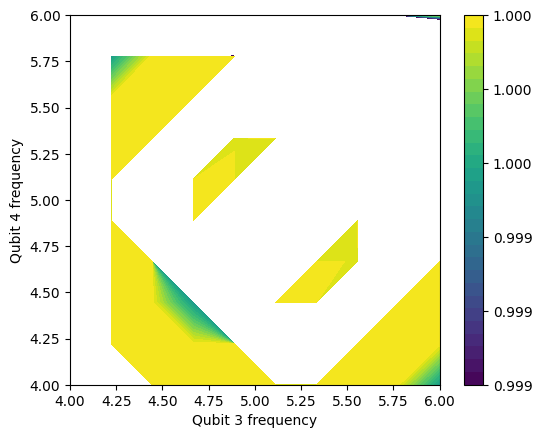

In [20]:
# plotting the data 
fig, ax = plt.subplots()

ticks = np.linspace(.999, 1, 6)
levels = np.linspace(.999, 1, 30) 

CS = ax.contourf(x, y, fidelities, cmap="viridis", levels=levels)
ax.set_aspect('equal')
ax.set_xlabel('Qubit 3 frequency')
ax.set_ylabel('Qubit 4 frequency')

fig.colorbar(CS, format="%.3f", ticks=ticks)

In [17]:
# this experiment above is incomplete unless more gates are simulated
# otherwise you know only the restrictions on the qubits relative to only one of the gates